In [29]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
from sklearn.model_selection import KFold
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
#Plotting function
from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
m = ModelPredictionPlots()

Validation functions


## Get Data for training and testing

In [16]:
task_dict = {'Task1':'1 Fam Rew', 
             'Task2':'2 No Rew', 
             'Task3':'3 Fam Rew', 
             'Task4':'4 Nov Rew'}

In [17]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR6/'

frame_lick_stop = 5154
task_numframes = {'Task1': 20000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [18]:
SaveResults = os.path.join(FolderName, 'DecoderResults', 'RNNDecoder')
if not os.path.exists(SaveResults):
    os.mkdir(SaveResults)

In [19]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task1 is 92
Number of PlaceCells in Task2 is 97
Number of PlaceCells in Task2a is 87
Number of PlaceCells in Task4 is 80
Number of PlaceCells in Task3 is 82


In [20]:
# Get Xdata - calcium data and Ydata - running behavior
X = A.Fc3data_dict['Task1'][:, A.Parsed_Behavior['good_running_index'].item()['Task1']].T[:11100, :]
Y = A.Parsed_Behavior['good_running_data'].item()['Task1'][:11100]
print(np.shape(X), np.shape(Y))

(11100, 316) (11100, 1)


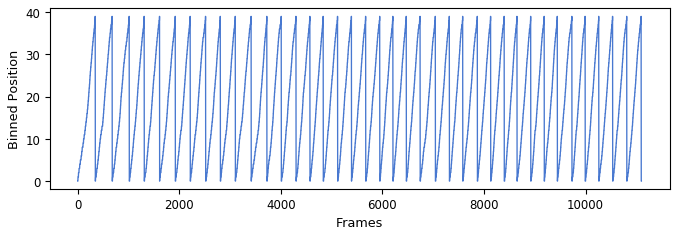

In [21]:
from RunKeras import PrepareBehaviorData as pbd
B = pbd(BehaviorData=Y, tracklength=tracklength, trackbins=trackbins)
y_cat = B.position_onehotencoded

### Create X with history

In [31]:
from RunKeras import SimpleRNN as sRNN
bins_before = 15
bins_after = 15
bins_current = 1
X_withhist = sRNN().create_X_Withhistory(neural_data=X, bins_before=bins_before,
                                         bins_after=bins_after, bins_current=bins_current)
print(np.shape(X_withhist))

(11100, 31, 316)


In [32]:
#Split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X_withhist, y_cat, test_size=0.10, random_state=None, shuffle=False)
print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(9990, 31, 316) (1110, 31, 316) (9990, 40) (1110, 40)


In [34]:
# Save ground truth
np.savez(os.path.join(SaveResults, 'ground_truth.npz'), X=X, X_withhistory=X_withhist, y=y_cat,
         X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, 
         bins_before=bins_before, bins_after=bins_after, bins_current=bins_current)

### Run LSTM with different parameters

In [24]:
RNNmodel = sRNN().fit_LSTM(X_train, y_train, epochs=5)

Epoch 1/5
9990/9990 [==============================] - 24s 2ms/step - loss: 0.0154 - acc: 0.5844
Epoch 2/5
9990/9990 [==============================] - 23s 2ms/step - loss: 0.0098 - acc: 0.7778
Epoch 3/5
9990/9990 [==============================] - 24s 2ms/step - loss: 0.0078 - acc: 0.8154
Epoch 4/5
9990/9990 [==============================] - 23s 2ms/step - loss: 0.0068 - acc: 0.8372
Epoch 5/5
9990/9990 [==============================] - 7s 678us/step

Accuracy of training set: 87.48%


1095/1095 [==============================] - 1s 629us/step

Accuracy of test set:: 60.64%


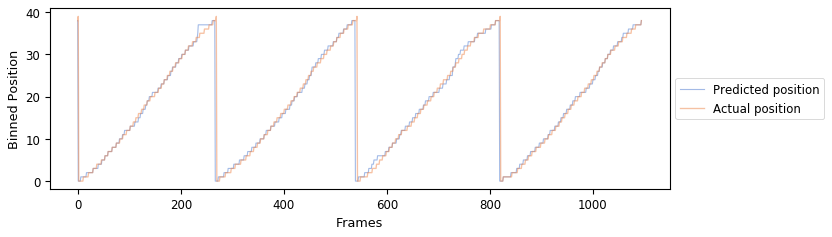

In [27]:
y_predicted = sRNN().validate_model(RNNmodel, X_test[:-bins_after, :], y_test[:-bins_after])

In [37]:
R2 = m.get_R2(np.argmax(y_test, 1)[:-bins_after], y_predicted)
rho = m.get_rho(np.argmax(y_test, 1)[:-bins_after], y_predicted)
print(f'R2: %.2f' %R2)
print(f'rho: %.2f' %rho)

R2: 0.90
rho: 0.95


In [35]:
# serialize model to JSON
model_json = RNNmodel.to_json()
with open(os.path.join(SaveResults, "Trainandvalidatedmodel.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
RNNmodel.save_weights(os.path.join(SaveResults, "Trainandvalidatedmodel.h5"))

In [36]:
np.savez(os.path.join(SaveResults, 'Trainandvalidatedmodelparams.npz'),
         y_actual=y_test, y_predicted=y_predicted, R2=R2, rho=rho)